# Pavement condition analysis

In [141]:
%matplotlib inline

In [142]:
## Import required modules
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from os.path import join
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from sklearn import svm, metrics, utils
from sklearn import cross_validation as cv
from sklearn import naive_bayes as nb
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV

In [143]:
## Define a few constants
PATH = '/Users/andreavaccari/Desktop/W7/Pavement_Conditions/Processed/'
SRC = ['ORIGINAL', 'DESPECKLED']
YEAR = ['_2012', '_2013', '_2014']
TYPE = ['_IS', '_PR', '_SC']
TYPE = ['_PR']
PD_TYP = ['_winter', '_year', '_all']
FEAT = '_AMP_SHP_DIF'
CORR = '_many'
PD_EXT = '.pkl'
DAT = 'CCI Class'
CCI_CLASS = {0.0:'Very Poor (0-49)',
             1.0:'Poor (50-59)', 
             2.0:'Fair (60-69)', 
             3.0:'Good (70-89)', 
             4.0:'Excellent (90-100)'}

## Preiliminary analysis
The data was subdivided in several files. Each file contains the amplitude data relative a particular type of road (interstate, primary and scondary) and limited to the winter period around the date when the quality of the pavement was assessed. The original pavement assessment data are provided as a series of record indicating various parameters of the measurement for each $1/10^{th}$ of a mile segment. To insure spatial coherence, the amplitude value are selected only from the pixel identified by the starting GPS coordinates for each segment.

Each record includes a pavement quality parameter CCI. Furthermore a CCI class entry has been added that aggregates CCI entries based on ranges defines by VDOT (table below).

After looking at the distributions derived for each of the CCI classes, we noticed an underlying separation between _excellent_, _good_ and _fair_, _poor_ and _very poor_ classes. Because of this, we further classified the data within two main categories __good__ and __bad__, assigned as shown in the following table.

|Pavement Condition|Index Scale (CCI)|Global classes|
|------------------|:---------------:|:------------:|
|Excellent	       |90 and above     |good          |
|Good              |70-89            |good          |
|Fair              |60-69            |bad           |
|Poor              |50-59            |bad           |
|Very Poor         |49 and below     |bad           |

From now on, we will work on the assumption that:
- we have two classes (**good** and **bad**)
- we want to detect the **bad**


In [144]:
## Load data from files and separate according to CCI and global classes
dat = {}
gvb = {}
# Extract amplitude data from a given road type and assign to CCI classes
for y in YEAR:
    for t in TYPE:
        name = SRC[0] + y + t + PD_TYP[0] + FEAT + CORR + PD_EXT
        df = pd.read_pickle(join(PATH, name))
        df_fil = df.filter(regex='(' + DAT + '|^A[0-9]{8})')
        for r in df_fil.iterrows():
            row = r[1].tolist()
            dat.setdefault(row[0], {'amp': []})
            dat[row[0]]['amp'].extend(row[1:])
            dat_siz += len(row[1:])
            if row[0] < 3:
                gvb.setdefault('bad', {'amp': []})
                gvb['bad']['amp'].extend(row[1:])
            else:
                gvb.setdefault('good', {'amp': []})
                gvb['good']['amp'].extend(row[1:])

## Data fitting
Due to the nature of the phenomenon generating the observations, the data should be Rayleigh distributed. Let's verify this assumption.

(5.2187850193215901, -0.23355042485085406, 3.3705376673901313) 26604


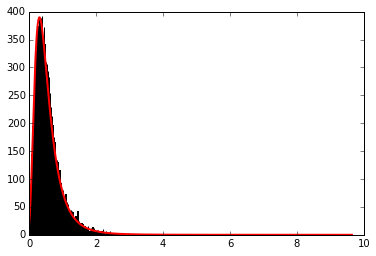

In [145]:
rd = stats.invgamma
data = dat[0.0]['amp']
data = gvb['good']['amp']
dt = np.asarray(data)
par = rd.fit(dt)
print par, len(data)
rdf = rd(*par[:-2], loc=par[-2], scale=par[-1])
pts = 1000
rng = bins=np.linspace(dt.min(), dt.max(), pts)
plt.hist(dt, rng)
plt.plot(rng, rdf.pdf(rng)*len(dt)*(dt.max()-dt.min())/pts, linewidth=2, color='r')

## 1D Analysis
Let's considered the ensable of the amplitude data in each of the classes as samples drawn from an unknown underlying distribution. Let's look at the distributions for all individual classes and for the subdivision in **good** (excelent + good) and **bad** (very poor + poor + fair).

The distribution were evaluated using a KDE with Gaussian kernel on the $\log_{10}$-compressed amplitude data. The compression was implemented to both remove the effects of saturation and move from the multiplicative noise model due to the presence of speckle to an additive one. The bandwidths were evaluated offline using a 3-fold cross validation approach as implemented by the `GridSearchCV` class within _scikit-learn_. The results were very close to each other and close to `0.07` so we implemented that as bandwidth value.

Class: Very Poor (0-49) (0.0)	(Min, Max): (0.02, 2.45)  Mean: 0.61  Stdev: 0.39  Count:   1601 (5.12%)
Class: Poor (50-59) (1.0)	(Min, Max): (0.02, 4.07)  Mean: 0.63  Stdev: 0.46  Count:   1283 (4.10%)
Class: Fair (60-69) (2.0)	(Min, Max): (0.02, 3.18)  Mean: 0.63  Stdev: 0.41  Count:   1767 (5.65%)
Class: Good (70-89) (3.0)	(Min, Max): (0.01, 4.76)  Mean: 0.55  Stdev: 0.39  Count:   8351 (26.72%)
Class: Excellent (90-100) (4.0)	(Min, Max): (0.00, 9.64)  Mean: 0.58  Stdev: 0.52  Count:  18253 (58.40%)

Class: bad			(Min, Max): (0.02, 4.07)  Mean: 0.63  Stdev: 0.42  Count:   4651 (14.88%)
Class: good			(Min, Max): (0.00, 9.64)  Mean: 0.57  Stdev: 0.48  Count:  26604 (85.12%)


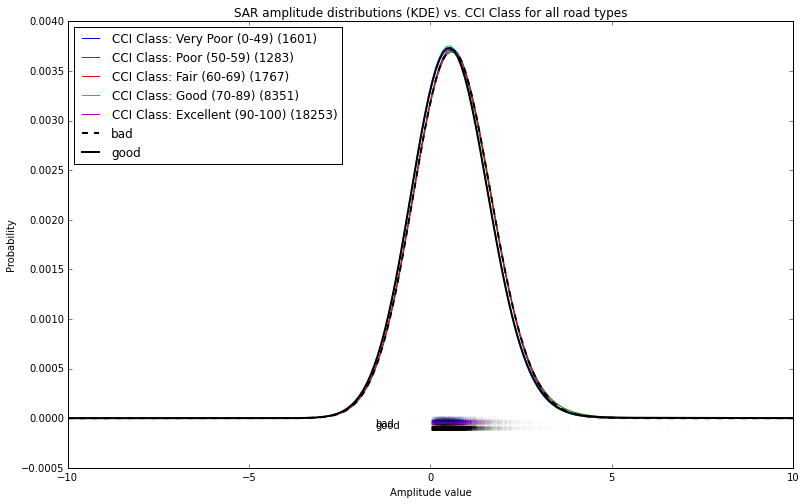

In [146]:
# Display the amplitude distribution for all classes
fig = plt.figure(figsize=(13.0, 8.0))
plt.title('SAR amplitude distributions (KDE) vs. ' + DAT + ' for all road types')
plt.xlabel('Amplitude value')
plt.ylabel('Probability')
xlim = [-10.0, 10.0]
xgrid = np.linspace(xlim[0], xlim[1], 200)
dx = np.diff(xlim)/200

color = {0.0: 'b', 1.0: 'g', 2.0: 'r', 3.0: 'c', 4.0: 'm'}
gvbst = {'good': 'solid', 'bad': 'dashed'}

# Define kernel density estimator
kde = KernelDensity(bandwidth=1)

for k, v in dat.iteritems():
    amp = np.asarray(v['amp'])
    print "Class: {} ({})\t(Min, Max): ({:3.2f}, {:3.2f})  Mean: {:3.2f}  Stdev: {:3.2f}  Count: {:6d} ({:3.2%})".format(CCI_CLASS[k], k, amp.min(), amp.max(), amp.mean(), amp.std(), len(amp), float(len(amp))/dat_siz)
    
    kde.fit(amp[:, np.newaxis])
    y = np.exp(kde.score_samples(xgrid[:, np.newaxis])) * dx

    plt.plot(xgrid, y * dx, label='CCI Class: {0} ({1})'.format(CCI_CLASS[k], len(amp)), color=color[k])
    plt.scatter(amp, -0.00001 * k * np.ones(len(amp)), c=color[k], alpha=0.0075, marker='|')

print

for k, v in gvb.iteritems():
    amp = np.asarray(v['amp'])
    print "Class: {}\t\t\t(Min, Max): ({:3.2f}, {:3.2f})  Mean: {:3.2f}  Stdev: {:3.2f}  Count: {:6d} ({:3.2%})".format(k, amp.min(), amp.max(), amp.mean(), amp.std(), len(amp), float(len(amp))/dat_siz)

    kde.fit(amp[:, np.newaxis])
    y = np.exp(kde.score_samples(xgrid[:, np.newaxis])) * dx

    plt.plot(xgrid, y * dx, color='k', linewidth=2, linestyle=gvbst[k], label=k)
    if k == 'good':
        plt.scatter(amp, -0.0001 * np.ones(len(amp)), c='k', alpha=0.0075, marker='|')
        plt.text(-1.5, -0.0001, 'good')
    else:
        plt.scatter(amp, -0.00008 * np.ones(len(amp)), c='k', alpha=0.0075, marker='|')
        plt.text(-1.5, -0.00008, 'bad')

plt.xlim(xlim)
plt.legend(loc=2)

The first noticeable property of the global classes is the _disparity_ in the population. This, together with the large overlap between the classes, might cause a _1D classifier_ to choose an extreme value for the threshold location since the resulting accuracy $(TP + TN)/Tot$ will be at least equal to the percentage of the largest class 72.6%. We will have to consider these factors when analyzing the data and compensate for them.

In [147]:
# Build a feature array and a label array from the good and bad datasets
goodamp = gvb['good']['amp']
badamp = gvb['bad']['amp']
buf = np.hstack((goodamp, badamp))
X = np.ndarray((len(buf), 1), buffer=buf)  # Define features (1D)
y = ['good'] * len(goodamp) + ['bad'] * len(badamp)  # Define labels (0-bad, 1-good)
cX, cy = utils.shuffle(X, y)  # Shuffle the dataset to remove index dependance

###Naive Bayes classifier
The naive Bayes classifier makes the assumption that all the pairs within a class are independent samples from the underlying distribution. Although this is not necessarily entirely true in our case since the samples are derived from time series of observation over individual pixels, our assumption is that, broadly speaking, the diffusion mechanism behind each observation depends only on the state of the road.

The `scikit-learn` implementation of the classifier assumes that $P(x_{i}|y)$ is Gaussian. Once again, this is not the case. Our distributions are _log10-Rayleigh_ but, we will allow for the approximation and verify the results.

One of the nice things about this classifier is that it automatically takes care of the skew in the classes frequency when evaluating $P(y_{i})$. Unfortunately, this is also the downfall of this method in our case due to the large overlap between the distribution as we will show.

In [148]:
# Define the classifier
cfr = nb.GaussianNB()

In [149]:
# Train the classifier
cfr.fit(cX, cy)
for i in range(len(cfr.classes_)):
    print u"Class: '{}'\t{}\t({:3.2%})\t(\u03BC, \u03C3) = ({:3.2f}, {:3.2f})".format(cfr.classes_[i], cfr.class_count_[i], cfr.class_prior_[i], float(cfr.theta_[i]), np.sqrt(float(cfr.sigma_[i])))   

Class: 'bad'	4651.0	(14.88%)	(μ, σ) = (0.63, 0.42)
Class: 'good'	26604.0	(85.12%)	(μ, σ) = (0.57, 0.48)


As we can see the naive Bayes classifier has correctly identified the two classes and evaluated both the priors and the best fitting Gaussians.

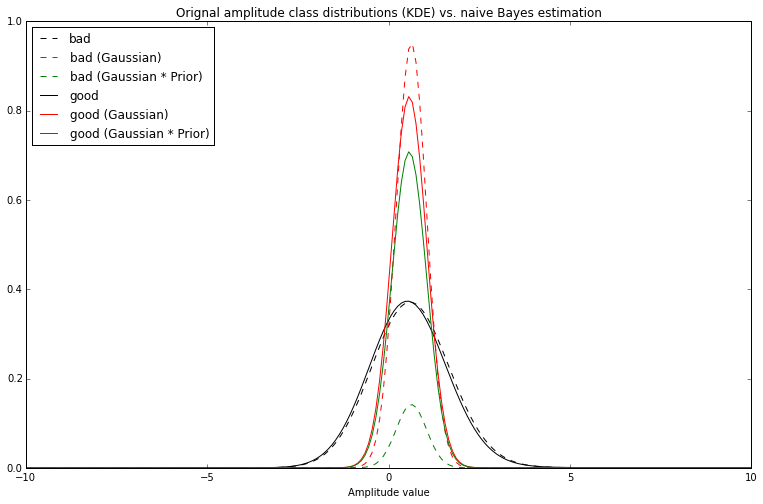

In [150]:
# Display the amplitude distribution for all classes
fig = plt.figure(figsize=(13.0, 8.0))
plt.title('Orignal amplitude class distributions (KDE) vs. naive Bayes estimation')
plt.xlabel('Amplitude value')
xlim = [-10.0, 10.0]
xgrid = np.linspace(xlim[0], xlim[1], 200)
dx = np.diff(xlim)/200

sty = {'good': 'solid', 'bad': 'dashed'}

# Define kernel density estimator
kde = KernelDensity(bandwidth=1)

for n, (k, v) in enumerate(gvb.iteritems()):
    amp = np.asarray(v['amp'])

    kde.fit(amp[:, np.newaxis])
    y = np.exp(kde.score_samples(xgrid[:, np.newaxis]))

    plt.plot(xgrid, y, color='k', linestyle=sty[k], label=k)
    gauss = stats.norm(loc=float(cfr.theta_[n]), scale=np.sqrt(float(cfr.sigma_[n])))
    plt.plot(xgrid, gauss.pdf(xgrid), color='r', linestyle=sty[k], label=k + ' (Gaussian)')
    plt.plot(xgrid, cfr.class_prior_[n] * gauss.pdf(xgrid), color='g', linestyle=sty[k], label=k + ' (Gaussian * Prior)')
    
plt.xlim(xlim)
plt.legend(loc=2)

As it can be notice in the above plot, due to the overlap of the distributions, the use of the priors completely skews the classification towards the most abbundant class. 

In [151]:
print "--- Naive Bayes classifier ---"
print "- With priors based on class population -"
print "Confusion matrix:"
print metrics.confusion_matrix(cy, cfr.predict(cX))
print "Classification report:"
print metrics.classification_report(cy, cfr.predict(cX))
print "Accuracy: {:3.2%}".format(cfr.score(cX, cy))

print "\n- Without priors -"
cfr.class_prior_ = [0.5, 0.5]
print "Confusion matrix:"
print metrics.confusion_matrix(cy, cfr.predict(cX))
print "Classification report:"
print metrics.classification_report(cy, cfr.predict(cX))
print "Accuracy: {:3.2%}".format(cfr.score(cX, cy))

--- Naive Bayes classifier ---
- With priors based on class population -
Confusion matrix:
[[    0  4651]
 [    0 26604]]
Classification report:
             precision    recall  f1-score   support

        bad       0.00      0.00      0.00      4651
       good       0.85      1.00      0.92     26604

avg / total       0.72      0.85      0.78     31255

Accuracy: 85.12%

- Without priors -
Confusion matrix:
[[ 3226  1425]
 [17310  9294]]
Classification report:
             precision    recall  f1-score   support

        bad       0.16      0.69      0.26      4651
       good       0.87      0.35      0.50     26604

avg / total       0.76      0.40      0.46     31255

Accuracy: 40.06%


In [152]:
print cv.cross_val_score(cfr, cX, cy, cv=cv.StratifiedShuffleSplit(cy), n_jobs=-1)

[ 0.8512476  0.8512476  0.8512476  0.8512476  0.8512476  0.8512476
  0.8512476  0.8512476  0.8512476  0.8512476]
